# SNP Data Analysis
                                                                                                   - Gaurika Tyagi

Single Nucleotide Polymorphisms (SNPs) may be quantified as predictor variables in order to look for associations with a given phenotype, such as a disease. In this analysis we will investigate the dataset disease.arff containing genomic data on 2000 individuals, some of whom have the disease and some of whom do not (categorised by "labels" column). 

 Each row contains data on one individual. 

 There are 10 predictor variables: SNPs encoded as number of mutated alleles for the gene. 

 The labels variable: Indicates whether a person has the disease (1 if they have it, 0 if not).

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.grid_search as grid_search
import sklearn.cross_validation as crossval
import sklearn.metrics as metric
import sklearn.svm as svm

import os
import arff
import scipy

from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

## Read and Pre-process Data

In [4]:
data_generator = arff.load(os.path.join(os.path.dirname(os.path.abspath("__file__")), "disease2a.arff"))

location1 = []
location2 = []
location3 = []
location4 = []
location5 = []
location6 = []
location7 = []
location8 = []
location9 = []
location10 = []
age = []
labels = []

for line in data_generator:
    location1.append(int(str(line.location1).replace("'","")))
    location2.append(int(str(line.location2).replace("'","")))
    location3.append(int(str(line.location3).replace("'","")))
    location4.append(int(str(line.location4).replace("'","")))
    location5.append(int(str(line.location5).replace("'","")))
    location6.append(int(str(line.location6).replace("'","")))
    location7.append(int(str(line.location7).replace("'","")))
    location8.append(int(str(line.location8).replace("'","")))
    location9.append(int(str(line.location9).replace("'","")))
    location10.append(int(str(line.location10).replace("'","")))
    labels.append(int(str(list(line)[-1]).replace("'","")))
data = pd.DataFrame({"location1": location1, "location2": location2,
                     "location3": location3, "location4": location4,
                     "location5": location5, "location6": location6,
                     "location7": location7, "location8": location8,
                     "location9": location9, "location10": location10,
                     "labels": labels
                    })

data.tail(5)

,labels,location1,location10,location2,location3,location4,location5,location6,location7,location8,location9
1995,1,0,0,0,1,0,2,2,0,0,2
1996,0,0,2,0,0,0,1,1,0,0,2
1997,0,1,2,0,0,0,1,1,1,1,2
1998,1,0,2,1,2,1,0,0,1,0,0
1999,0,1,2,0,0,1,1,2,0,0,0


We now have a dataframe with all numeric values. But, we know that the location of SNPs is a nominal variable and labels is a categorical variable. Let us go ahead and change the corresponding data types.

In [5]:
categorizer = lambda x: x.astype("category") if x.name == "labels" else x.astype("category", ordered = True)
data_x = data.ix[:, data.columns != "labels"].apply(categorizer)
data_y = data.ix[:,data.columns == "labels"].apply(categorizer)

In [6]:
data_x.describe()

,location1,location10,location2,location3,location4,location5,location6,location7,location8,location9
count,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
unique,3,3,3,3,3,3,3,3,3,3
top,0,1,0,1,0,1,1,0,0,0
freq,1025,1166,1151,920,1319,1148,888,1148,1416,916


We have confirmed that the data has been read in correctly.

There are 2000 observations, each SNP location has 3 possible values: 0, 1 or 2
Along with this we can even see that SNP location8 has the highest occurences.

In [7]:
data_y.describe()

,labels
count,2000
unique,2
top,1
freq,1050


The y-labels: disease presence suggests that out of 2000 people in this data set, 1445 have a disease.

# Descriptive Analysis

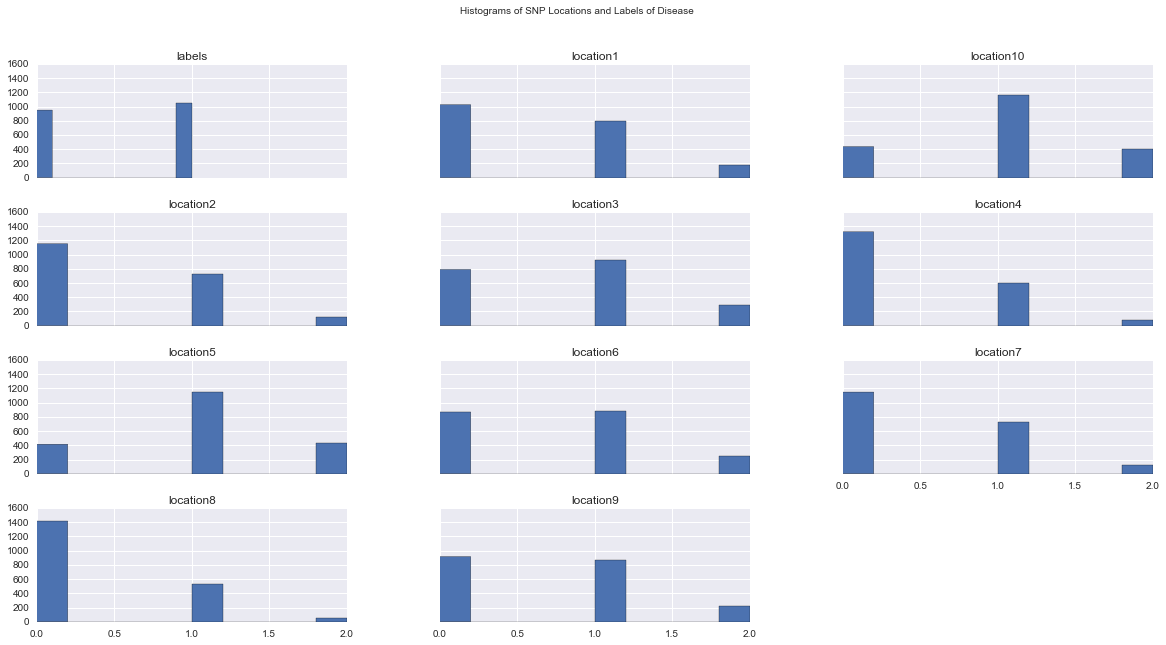

In [14]:
data.hist(figsize=(20,10), sharex=True, sharey=True)
plt.suptitle("Histograms of SNP Locations and Labels of Disease")
plt.show()

### SCATTER PLOT DISTRIBUTION OF ALL SNPs

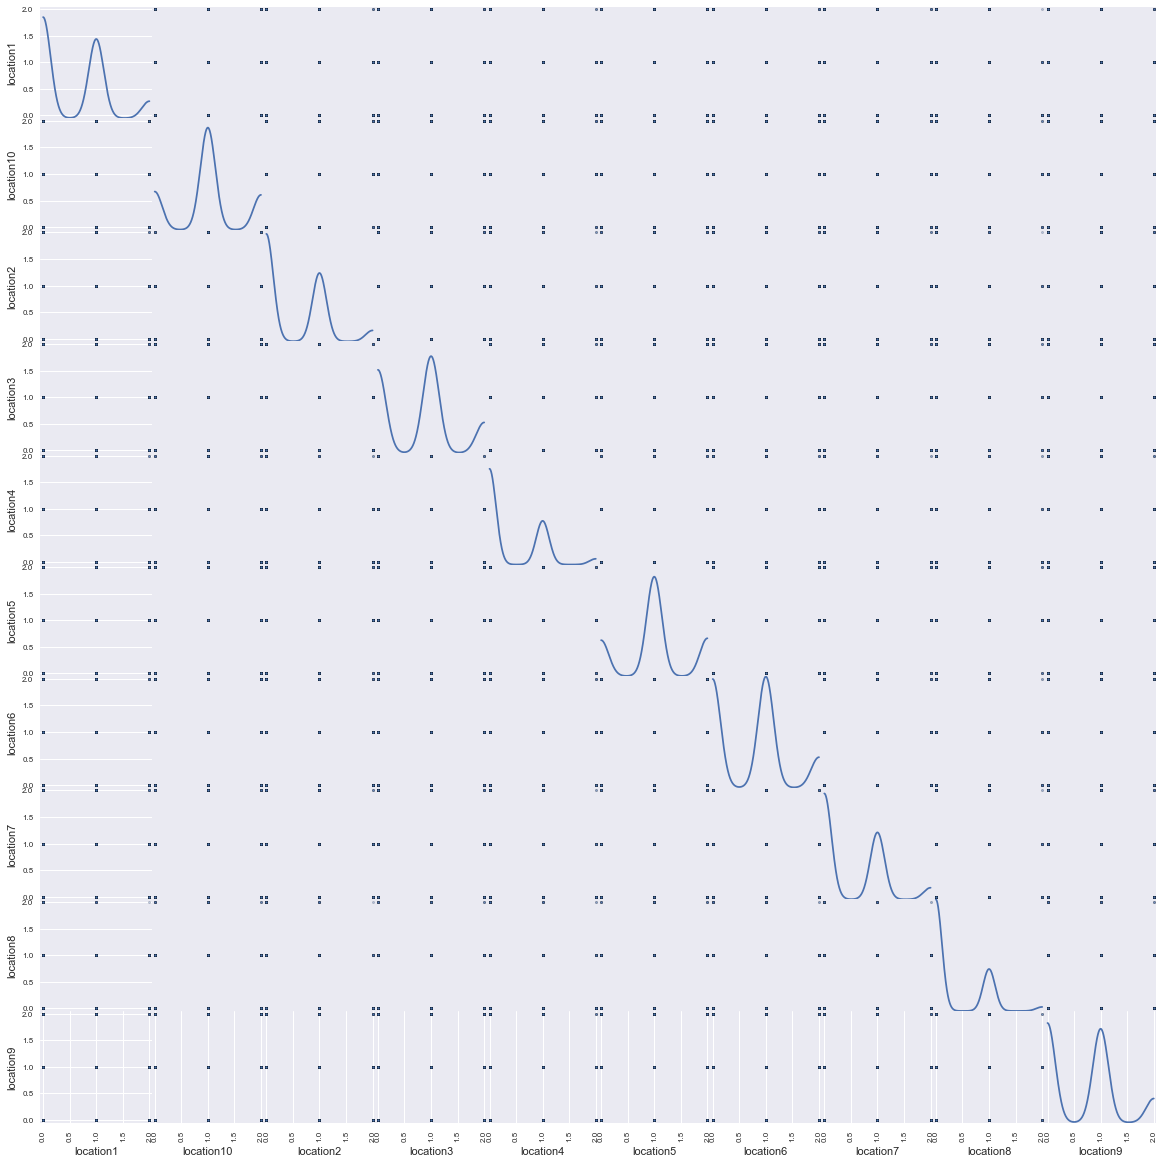

In [15]:
pd.tools.plotting.scatter_matrix(data.ix[:, data.columns != "labels"], alpha=0.2, figsize=(20, 20), diagonal='kde')
plt.show()

We can show the correlations between all features as shown below.

### CORRELATIONS

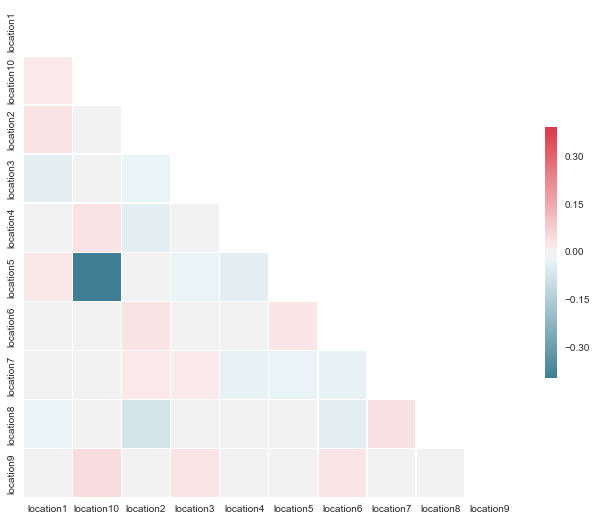

In [16]:
sns.set(style="white")

# Generate a large random dataset
corr = data.ix[:, data.columns != "labels"].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

1. This shows that a SNP at location 5 and that at location 10 are very unlikely

2. Location8 and location2 are also unlikely to be found together

2. SNPs at location1 and location2 will mostly occur simultaneously

3. SNPs in location8 and location7 have high chances of occuring together

## Feature Importance

Using a random forest, we will rank the variables by their importance in classifying diseases

In [50]:
def feature_reduction_importance (train_x, train_y):
    """
    Uses the ExtraTreesClassifier ensemble to determine which features are most important in the entire feature set.
    It fits a model based on train_x and train_y and keeps features whichever have an importance higher than 0.15. It
    also plots the feature importance in the original train set.
    :param train_x: features which are to be fit in to the machine learning model
    :param train_y: labels which are associated with train_x
    :return keep_feature: A boolean array of what features to keep and what features to discard.
    """
    clf = ExtraTreesClassifier(random_state = 9)
    clf.fit(train_x, train_y)
    importances = clf.feature_importances_
    print pd.DataFrame({"Columns":train_x.columns, "importances": importances})
    avg_imp = sum(importances)/len(importances)
    print "Average Importance of th features:", avg_imp
    keep_feature =[]
    for imp in importances:
        if imp < avg_imp*0.75:
            keep_feature.append(False)
        else:
            keep_feature.append(True)
    return keep_feature

In [51]:
data_train, data_test = crossval.train_test_split(data, test_size = 0.33, random_state = 124)

train_x_raw1 = data_train.ix[:, data_train.columns != "labels"]
train_y = data_train.ix[:, data_train.columns == "labels"]
test_x_raw1 = data_test.ix[:, data_test.columns != "labels"]
test_y = data_test.ix[:, data_test.columns == "labels"]

In [53]:
keep_features = train_x_raw1.columns[feature_reduction_importance(train_x_raw1, train_y)]
print "Features to be kept:", keep_features

      Columns  importances
0   location1     0.048160
1  location10     0.248709
2   location2     0.073469
3   location3     0.078296
4   location4     0.065810
5   location5     0.214673
6   location6     0.070329
7   location7     0.061096
8   location8     0.060664
9   location9     0.078793
Average Importance of th features: 0.1
Features to be kept: Index([u'location10', u'location3', u'location5', u'location9'], dtype='object')


/Users/gaurikatyagi/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


<b>Since only  location10, location3, location5, and location9 are above the average importance, we will keep only these for further analysis.</b>

In [54]:
def reduce_features (train_x, test_x, selection_array):
    """
    This function gets rid of the unwanted features in the test and train set (as the ExtraTreesClassifier's
    transform function has been removed from sklearn). The selection array contains the name of the features to keep.
    :param train_x: features which are fit in to the machine learning model
    :param test_x: dataframe to be used for testing, based on the model already fit- only the features
    :param selection_array: the name of the features to keep. Column names of dataframe
    :return: data frame of test and train final features
    """
    new_train = train_x.ix[:, selection_array]
    new_test = test_x.ix[:, selection_array]
    return new_train, new_test

In [55]:
## Reducing features for both training and testing
train_x, test_x= reduce_features(train_x_raw1, test_x_raw1, keep_features)

# Prepared Data

## Training Data

In [56]:
train_x.head()

,location10,location3,location5,location9
942,1,1,1,0
1013,1,1,1,2
248,0,1,1,1
407,1,1,2,2
1763,0,2,2,0


In [57]:
train_y.head()

,labels
942,1
1013,1
248,0
407,0
1763,0


## Testing Data

In [58]:
test_x.tail()

,location10,location3,location5,location9
1543,2,1,1,2
656,0,0,2,0
1800,1,2,1,1
1029,1,1,1,1
1421,2,1,2,1


In [59]:
test_y.tail()

,labels
1543,0
656,1
1800,0
1029,0
1421,0


In [62]:
enc = preprocessing.OneHotEncoder()
data_hot_X = enc.fit(train_x) 
train_x = enc.transform(train_x).toarray()
test_x = enc.transform(test_x).toarray()

## Random Forests

In [63]:
def model_evaluation(model, test_x, test_y):
    predicted = model.predict(test_x)
    confusion_matrix=metric.confusion_matrix(test_y,predicted)
    sensitivity=float(confusion_matrix[1][1])/(float(confusion_matrix[1][1])+float(confusion_matrix[1][0]))
    specificity= float(confusion_matrix[0,0])/float(confusion_matrix[0,0]+confusion_matrix[0,1])
    accuracy=metric.accuracy_score(test_y,predicted)
    f1_score=metric.f1_score(test_y,predicted)
    false_positive_rate, true_positive_rate, thresholds = metric.roc_curve(test_y, predicted)
    roc_auc = metric.auc(false_positive_rate, true_positive_rate)
    evaluation_dictionary = {"sensitivity": sensitivity, "specificity": specificity, "accuracy": accuracy,
                             "f1_score": f1_score, "roc_auc": roc_auc}

    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc, lw=4, 
         color ="#0000ff", marker='s',markerfacecolor="red") 
    plt.plot([0,1],[0,1], "k--")
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.005])
    plt.title("Receiver Operating Characteristics for Testing Data- Logistic Regression")
    plt.legend(loc = "lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    return evaluation_dictionary

Random Forest Classifier Evaluation
Best estimator is:
{'max_features': 1, 'n_estimators': 100, 'bootstrap': True, 'random_state': 999}


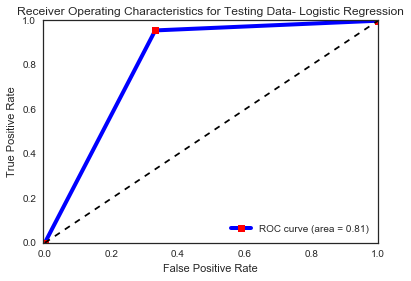

{'f1_score': 0.84536082474226804, 'roc_auc': 0.81251896883133612, 'sensitivity': 0.956268221574344, 'accuracy': 0.81818181818181823, 'specificity': 0.668769716088328}


In [64]:
def Random_Forest_Classifier(train_x, train_y):
    """
    A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the
    data-set and uses averaging to improve the predictive accuracy and control over-fitting. 
    The sub-sample size is always the same as the original input sample size but the samples are drawn with 
    replacement if bootstrap=True (default). In addition, when splitting a node during the construction of the tree, 
    the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the 
    best split among a random subset of the features. As a result of this randomness, the bias of the forest usually 
    slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also 
    decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.
    
    The main parameters to adjust when using these methods is n_estimators and max_features. The former is the number 
    of trees in the forest. The larger the better, but also the longer it will take to compute. The results stop 
    getting significantly better beyond a critical number of trees. The latter is the size of the random subsets of 
    features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater 
    the increase in bias. Empirical good default values are max_features=n_features for regression problems, 
    and max_features=sqrt(n_features) for classification tasks (where n_features is the number of features in
    the data). 
    
    Good results are achieved when setting max_depth=None in combination with min_samples_split=1
    
    :param train_x: numpy array of data to be used for training- only the features
    :param train_y: numpy array of data labels for train_x
    :return: return the instance of RandomForestClassifier class with train data fit in it
    """    
    parameters = [{'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100], 
                   # more the number of trees better the performance.
                   # Kept increasing the number of trees whenever the best_estimator was at the boundary
                    'max_features': [1, 2, 3, 4], # we have a total of 4 features
                    'bootstrap': [True, False],
                   'random_state': [999] # To ensure same performance everytime,
                }]
    random_forest_clf = RandomForestClassifier()
    clf = grid_search.GridSearchCV(random_forest_clf, parameters, n_jobs = -1) #uses all cores
    clf.fit(train_x,train_y)
    # print(clf.best_estimator_)
    return clf

print "Random Forest Classifier Evaluation"
rfc = Random_Forest_Classifier(np.array(train_x), np.array(train_y['labels']))
print "Best estimator is:\n", rfc.best_params_
evaluation_dictionary_rfc = model_evaluation(rfc, np.array(test_x), np.array(test_y['labels']))
print evaluation_dictionary_rfc

## Logistic Regression

In [69]:
def model_evaluation_logistic(model, test_x, test_y):
    predicted = model.decision_function(test_x)
    false_positive_rate, true_positive_rate, thresholds = metric.roc_curve(test_y, predicted) 
    roc_auc = metric.auc(false_positive_rate, true_positive_rate)

    predicted_new = model.predict(test_x)
    confusion_matrix=metric.confusion_matrix(test_y,predicted_new)
    sensitivity=float(confusion_matrix[1][1])/(float(confusion_matrix[1][1])+float(confusion_matrix[1][0]))
    specificity= float(confusion_matrix[0,0])/float(confusion_matrix[0,0]+confusion_matrix[0,1])
    accuracy=metric.accuracy_score(test_y,predicted_new)
    f1_score=metric.f1_score(test_y,predicted_new)
    evaluation_dictionary = {"sensitivity": sensitivity, "specificity": specificity, "accuracy": accuracy,
                             "f1_score": f1_score, "roc_auc": roc_auc}

    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc, lw=4, 
         color ="#0000ff", marker='s',markerfacecolor="red") 
    plt.plot([0,1],[0,1], "k--")
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.005])
    plt.title("Receiver Operating Characteristics for Testing Data- Logistic Regression")
    plt.legend(loc = "lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    return evaluation_dictionary


Logistic Regression Classifier Evaluation


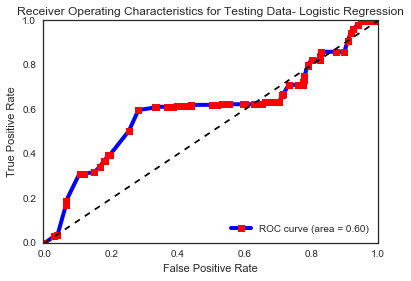

{'f1_score': 0.58953168044077131, 'roc_auc': 0.59953463133788887, 'sensitivity': 0.6239067055393586, 'accuracy': 0.54848484848484846, 'specificity': 0.4668769716088328}


In [70]:
def logistic_regression_classifier(train_x, train_y):
    """
    This function fits a logistic regression model
    :param train_data: numpy array- fits to the machine learning model
    :return lrc: instance of logistic regression model
    """
    # instantiate a logistic regression model, and fit with X and y
    lrc = linear_model.LogisticRegression()
    lrc = lrc.fit(train_x, train_y)
    return lrc

print "Logistic Regression Classifier Evaluation"
lrc = logistic_regression_classifier(np.array(train_x), np.array(train_y['labels']))
evaluation_dictionary_lrc = model_evaluation_logistic(lrc, np.array(test_x), np.array(test_y['labels']))
print evaluation_dictionary_lrc

## Naive Bayes

In [71]:
def model_evaluation_naive(model, test_x, test_y):
    predicted = model.predict_proba(test_x)
    false_positive_rate, true_positive_rate, thresholds = metric.roc_curve(test_y, predicted) 
    roc_auc = metric.auc(false_positive_rate, true_positive_rate)

    predicted_new = model.predict(test_x)
    confusion_matrix=metric.confusion_matrix(test_y,predicted_new)
    sensitivity=float(confusion_matrix[1][1])/(float(confusion_matrix[1][1])+float(confusion_matrix[1][0]))
    specificity= float(confusion_matrix[0,0])/float(confusion_matrix[0,0]+confusion_matrix[0,1])
    accuracy=metric.accuracy_score(test_y,predicted_new)
    f1_score=metric.f1_score(test_y,predicted_new)
    evaluation_dictionary = {"sensitivity": sensitivity, "specificity": specificity, "accuracy": accuracy,
                             "f1_score": f1_score, "roc_auc": roc_auc}

    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc, lw=4, 
         color ="#0000ff", marker='s',markerfacecolor="red") 
    plt.plot([0,1],[0,1], "k--")
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.005])
    plt.title("Receiver Operating Characteristics for Testing Data- Logistic Regression")
    plt.legend(loc = "lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    return evaluation_dictionary


Naive Bayes Classifier Evaluation


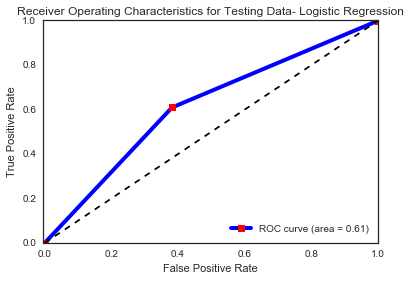

{'f1_score': 0.62109955423476959, 'roc_auc': 0.61381298801629702, 'sensitivity': 0.60932944606414, 'accuracy': 0.61363636363636365, 'specificity': 0.6182965299684543}


In [72]:
def gaussian_naive_bayes(train_x, train_y):
    """
    This function fits a gaussian naive bayes model
    :param train_x: numpy array- fits to the machine learning model
    :param train_y: labels- fits to the machine learning model
    :return lrc: instance of gaussian naive bayes model
    """
    gnb = GaussianNB().fit(train_x, train_y)
    return gnb

print "Naive Bayes Classifier Evaluation"
gnb = gaussian_naive_bayes(np.array(train_x), np.array(train_y["labels"]))
evaluation_dictionary_gnb = model_evaluation(gnb, np.array(test_x), np.array(test_y["labels"]))
print evaluation_dictionary_gnb

## Support Vector Machines

In [75]:
def model_evaluation_svm(model, test_x, test_y):
    predicted = model.decision_function(test_x)
    false_positive_rate, true_positive_rate, thresholds = metric.roc_curve(test_y, predicted) 
    roc_auc = metric.auc(false_positive_rate, true_positive_rate)

    predicted_new = model.predict(test_x)
    confusion_matrix=metric.confusion_matrix(test_y,predicted_new)
    sensitivity=float(confusion_matrix[1][1])/(float(confusion_matrix[1][1])+float(confusion_matrix[1][0]))
    specificity= float(confusion_matrix[0,0])/float(confusion_matrix[0,0]+confusion_matrix[0,1])
    accuracy=metric.accuracy_score(test_y,predicted_new)
    f1_score=metric.f1_score(test_y,predicted_new)
    evaluation_dictionary = {"sensitivity": sensitivity, "specificity": specificity, "accuracy": accuracy,
                             "f1_score": f1_score, "roc_auc": roc_auc}

    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc, lw=4, 
         color ="#0000ff", marker='s',markerfacecolor="red") 
    plt.plot([0,1],[0,1], "k--")
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.005])
    plt.title("Receiver Operating Characteristics for Testing Data- Logistic Regression")
    plt.legend(loc = "lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    return evaluation_dictionary


Support Vector Machine Classifier Evaluation
Best parameters set found on development:
{'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1}

Grid scores on development set:
0.528 (+/-0.001) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 0.0001}
0.528 (+/-0.001) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 0.001}
0.528 (+/-0.001) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 0.01}
0.528 (+/-0.001) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 0.1}
0.528 (+/-0.001) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 1}
0.528 (+/-0.001) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 10}
0.528 (+/-0.001) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001}
0.528 (+/-0.001) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001}
0.536 (+/-0.024) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01}
0.814 (+/-0.011) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1}
0.799 (+/-0.016) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 1}
0.799 (+/-0.016) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 10}
0.528 (+/-0.001) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.541 

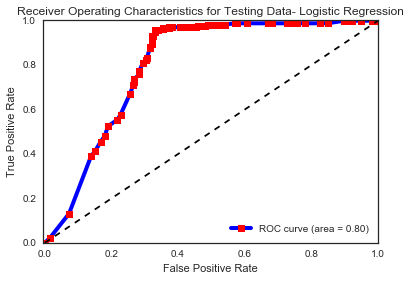

{'f1_score': 0.84536082474226804, 'roc_auc': 0.80308283746125753, 'sensitivity': 0.956268221574344, 'accuracy': 0.81818181818181823, 'specificity': 0.668769716088328}


In [77]:
def support_vector_machine(train_x, train_y):
    """
    coef0 is a parameter of the kernel projection, which can be used to overcome one of the important issues with the
    polynomial kernel. In general, just using coef0=0 should be just fine, but polynomial kernel has one issue,
    with p->inf, it more and more separates pairs of points, for which <x,y> is smaller than 1 and <a,b> with
    bigger value. It is because powers of values smaller than one gets closer and closer to 0, while the same power 
    of value bigger than one grows to infinity.
    :param train_x: numpy array- fits to the machine learning model
    :param train_y: labels- fits to the machine learning model
    :return: SVM model classifier
    """

    parameters = [{'kernel': ['rbf'], 'C': [0.01, 0.1, 1, 10],
                      'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]
                       },
                     {'kernel': ['poly'], 'C': [0.01, 0.1, 1, 10],
                      'degree': [1, 2]
                     },
                  {'kernel': ['poly'], 'C': [0.01, 0.1, 1],
                      'degree': [3]
                     }
                  ]
    svr = svm.SVC()
    clf = grid_search.GridSearchCV(svr, parameters, n_jobs = -1)
    clf.fit(train_x, train_y)
    print("Best parameters set found on development:")
    print(clf.best_params_)
    print
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print
    return clf
    
print "Support Vector Machine Classifier Evaluation"
svm_clf = support_vector_machine(np.array(train_x), np.array(train_y["labels"]))
evaluation_dictionary_svm_clf = model_evaluation_svm(svm_clf, np.array(test_x), np.array(test_y["labels"]))
print evaluation_dictionary_svm_clf

## WEKA Neural Network

We will use a neural network in Weka to classify the examples by disease status. Final results specify parameters such as the number of hidden nodes, learning rate, momentum and training time.

Scheme:       weka.classifiers.functions.MultilayerPerceptron -L 0.3 -M 0.2 -N 500 -V 0 -S 0 -E 20 -H a -B -C -I
Relation:     disease
Instances:    2000
Attributes:   11
              location1
              location2
              location3
              location4
              location5
              location6
              location7
              location8
              location9
              location10
              class
Test mode:    split 66.0% train, remainder test

Time taken to build model: 1.81 seconds

Training time: 500
Momentumm: 0.2
Learning Rate: 0.3
Number of Hidden Nodes: 'a' = (attribs + classes) / 2 = 12/2 = 6
 
=== Evaluation on test split ===

Time taken to test model on training split: 0.01 seconds

Correctly Classified Instances         535               78.6765 %
Incorrectly Classified Instances       145               21.3235 %
Kappa statistic                        0.5665
Mean absolute error                    0.2915
Root mean squared error                0.4033
Relative absolute error                58.4408 %
Root relative squared error            80.7706 %
Total Number of Instances              680     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.632    0.073    0.887      0.632    0.738      0.590    0.808     0.841     0
                 0.927    0.368    0.736      0.927    0.820      0.590    0.808     0.763     1
Weighted Avg.    0.787    0.228    0.807      0.787    0.781      0.590    0.808     0.800     

=== Confusion Matrix ===

   a   b   <-- classified as
 204 119 |   a = 0
  26 331 |   b = 1
